<a href="https://colab.research.google.com/github/Aleena-Mishra-10/first/blob/master/A_ICLR_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import shutil
import math
from PIL import Image


import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import add
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Lambda, concatenate, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D , Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [0]:
with zipfile.ZipFile("/content/drive/My Drive/ICLR Computer Vision for Crop Disease/train.zip","r") as zip_ref:
    zip_ref.extractall()

In [0]:
healthy_wheat = ['train/healthy_wheat/' + i for i in sorted(os.listdir('train/healthy_wheat'))]
leaf_rust = ['train/leaf_rust/' + i for i in sorted(os.listdir('train/leaf_rust'))]
stem_rust = ['train/stem_rust/' + i for i in sorted(os.listdir('train/stem_rust'))]

In [5]:
print('No of samples in healthy_wheat',len(healthy_wheat))
print('No of samples in leaf_rust',len(leaf_rust))
print('No of samples in stem_rust',len(stem_rust))

No of samples in healthy_wheat 142
No of samples in leaf_rust 358
No of samples in stem_rust 376


(3024, 4032, 3)


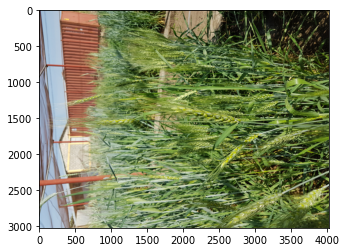

In [6]:
img = np.array(Image.open(healthy_wheat[3]))
print(img.shape)
plt.imshow(img)

In [7]:
all_files = np.array(healthy_wheat + leaf_rust + stem_rust)
np.random.shuffle(all_files)
print(len(all_files))

876


In [0]:
def read_image(file_loc, dim):
    img = Image.open(file_loc)
    img = img.resize(dim)
    img = np.array(img)
    return img

In [0]:
for c, i in enumerate(all_files):
  img = read_image(i, (256, 256))
  if len(img.shape) == 2:
    all_files = np.delete(all_files, c)

In [10]:
len(all_files)

875

In [0]:
train_files = all_files[:500]
valid_files = all_files[500:]

In [0]:
from albumentations import Compose, Resize, Flip, Rotate, ShiftScaleRotate, RandomBrightnessContrast, CLAHE, RandomCrop

In [0]:
class Generator(Sequence):

    label = { 'leaf_rust' : np.array([1, 0, 0]), 
              'stem_rust' : np.array([0, 1, 0]), 
              'healthy_wheat': np.array([0, 0, 1])}

    def __init__(self, x_set, batch_size=1, img_dim=(256, 256),augment=True):
        self.x = x_set
        self.batch_size = batch_size
        self.img_dim = img_dim
        self.augment = augment
        self.aug = Compose([Resize(height=256, width=256, always_apply=True),
                            Flip(p=0.5),
                            Rotate(p=0.5),
                            ShiftScaleRotate(p=0.5),
                            RandomBrightnessContrast(p=0.5),
                            CLAHE(p=0.5)], p=0.9)

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_x = np.array([read_image(img_id, self.img_dim) for img_id in batch])
        batch_y = np.array([self.label[img_id.split('/')[1]] for img_id in batch])

        if self.augment is True:
            batch_x = [self.aug(image=i)['image'] for i in batch_x]

        if self.batch_size==1:
            batch_x = np.squeeze(batch_x, 0)
            batch_y = np.squeeze(batch_y, 0)

        return batch_x/255, batch_y/1.0

In [0]:
def train_generator():
    generator = Generator(train_files, img_dim=(256,256))
    return generator
def valid_generator():
    generator = Generator(valid_files, img_dim=(256,256))
    return generator

ds_train = tf.data.Dataset.from_generator(
    train_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=([256,256,3], [3,])
    ).batch(10).repeat()

ds_valid = tf.data.Dataset.from_generator(
    valid_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=([256,256,3], [3,])
    ).batch(10).repeat()

In [0]:
def residual_module(layer_in, n_filters):
	merge_input = layer_in
	if layer_in.shape[-1] != n_filters:
		merge_input = Conv2D(n_filters, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
	conv1 = Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
	conv2 = Conv2D(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)
	layer_out = add([conv2, merge_input])
	layer_out = Activation('relu')(layer_out)
	return layer_out

In [25]:
visible = Input(shape=(256, 256, 3))
layer = residual_module(visible, 64)
model = Model(inputs=visible, outputs=layer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 256, 256, 64) 1792        input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_13[0][0]                  
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 256, 256, 64) 256         input_5[0][0]                    
______________________________________________________________________________________________

In [0]:
earlystopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=7,
    verbose=0,
    restore_best_weights=True)
reducelr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=0,
    min_delta=0.0001 )
callbacks = [earlystopping, reducelr]

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy',])

In [29]:
train_steps = len(train_files)//10
valid_steps = len(valid_files)//10

history = model.fit(
ds_train,
steps_per_epoch=train_steps,
epochs=50,
validation_data = ds_valid,
validation_steps = valid_steps,
callbacks=callbacks,
verbose=1
)

Train on 50 steps, validate on 37 steps
Epoch 1/50


InvalidArgumentError: ignored